<a href="https://colab.research.google.com/github/zeligism/ScaledVR/blob/main/Scaled_VR_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import sklearn
import time
from numba import njit
from sklearn.preprocessing import normalize
np.random.seed(123)

# Load data
data source: https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/

In [95]:
!wget https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a

--2022-01-17 21:55:47--  https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/a1a
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114818 (112K)
Saving to: ‘a1a.3’

a1a.3               100%[===================>] 112.13K   201KB/s    in 0.6s    

2022-01-17 21:55:49 (201 KB/s) - ‘a1a.3’ saved [114818/114818]



In [96]:
!head a1a

-1 3:1 11:1 14:1 19:1 39:1 42:1 55:1 64:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 3:1 6:1 17:1 27:1 35:1 40:1 57:1 63:1 69:1 73:1 74:1 76:1 81:1 103:1 
-1 4:1 6:1 15:1 21:1 35:1 40:1 57:1 63:1 67:1 73:1 74:1 77:1 80:1 83:1 
-1 5:1 6:1 15:1 22:1 36:1 41:1 47:1 66:1 67:1 72:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 16:1 22:1 36:1 40:1 54:1 63:1 67:1 73:1 75:1 76:1 80:1 83:1 
-1 2:1 6:1 14:1 20:1 37:1 41:1 47:1 64:1 67:1 73:1 74:1 76:1 82:1 83:1 
-1 1:1 6:1 14:1 22:1 36:1 42:1 49:1 64:1 67:1 72:1 74:1 77:1 80:1 83:1 
-1 1:1 6:1 17:1 19:1 39:1 42:1 53:1 64:1 67:1 73:1 74:1 76:1 80:1 83:1 
-1 2:1 6:1 18:1 20:1 37:1 42:1 48:1 64:1 71:1 73:1 74:1 76:1 81:1 83:1 
+1 5:1 11:1 15:1 32:1 39:1 40:1 52:1 63:1 67:1 73:1 74:1 76:1 78:1 83:1 


In [97]:
# see  https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_svmlight_file.html
from joblib import Memory
from sklearn.datasets import load_svmlight_file
mem = Memory("./mycache")

@mem.cache
def get_data(filePath):
    data = load_svmlight_file(filePath)
    return data[0], data[1]

X, y = get_data("a1a")
n, d =X.shape
#X = normalize(X, norm='l2', axis=1)
print("We have %d samples, each has up to %d features"%(n,d))

We have 1605 samples, each has up to 119 features


# Logistic Loss

$$
F(w) = \frac1n \sum_{i=1}^n \log(1+e^{-y_i x_i^T w})
$$

In [98]:
@njit
def logistic_loss_jit(X,y,w):
  ...

@njit
def logistic_loss_grad_jit(X,y,w):
  ...

def logistic_loss(X,y,w):
  return np.mean(np.log(1+np.exp(-y*X.dot(w))))

def logistic_loss_grad(X,y,w):
  r = -y * X.dot(w)
  expr = np.exp(r)
  grad = X.T.dot(-expr/(1+expr)*y)
  return grad

def F(X, y, w, i=None):
  if i is not None:
    if isinstance(i, int):
      i = [i]
    y = y[i]
    X = X[i,:]
  return logistic_loss(X,y,w)


def grad(X, y, w, i=None):
  n = X.shape[0]
  if i is not None:
    if isinstance(i, int):
      i = [i]
    n = len(i)
    y = y[i]
    X = X[i,:]
  return logistic_loss_grad(X,y,w) / n

In [99]:
X.shape[0]*X.shape[1]

190995

# SGD

In [100]:
%%time
def SGD(X, y, gamma=0.01, BS=1, T=10000):
  data = []
  w = np.random.randn(X.shape[1])  # initalize w randomly
  for it in range(T):
    indices = np.random.choice(X.shape[0], BS)
    w = w - gamma * grad(X,y,w,indices)
    data.append(( F(X,y,w) , np.linalg.norm(grad(X,y,w))**2 ))
  return w, np.array(data)

_, data = SGD(X,y)

CPU times: user 6.49 s, sys: 17.3 ms, total: 6.51 s
Wall time: 6.52 s


Text(0.5, 0, 'iteration $t$')

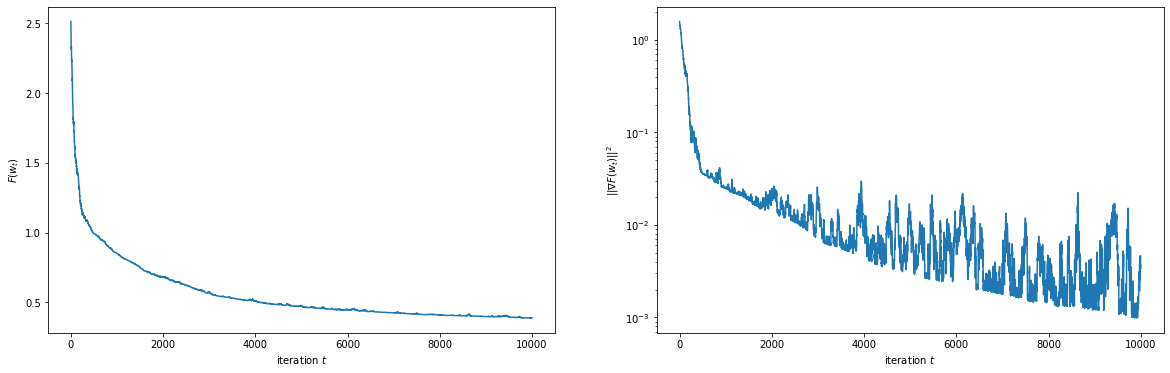

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2);fig.set_size_inches(20, 6)
ax1.plot(data[:,0]);ax1.set_ylabel(r"$F(w_t)$");ax1.set_xlabel(r"iteration $t$")  
ax2.semilogy(data[:,1]);ax2.set_ylabel(r"$||\nabla F(w_t)||^2$");ax2.set_xlabel(r"iteration $t$") 

CPU times: user 6.42 s, sys: 30.6 ms, total: 6.45 s
Wall time: 6.45 s


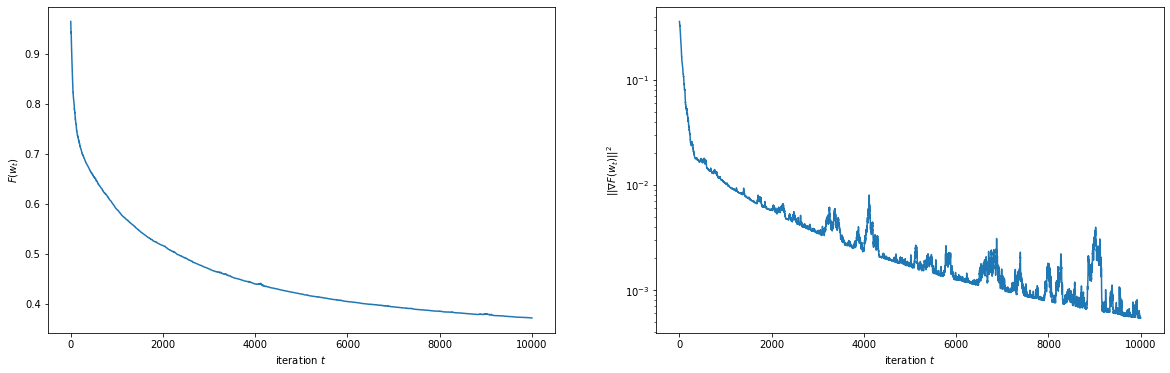

In [102]:
%%time
_, data = SGD(X,y,BS=10)
fig, (ax1, ax2) = plt.subplots(1, 2);fig.set_size_inches(20, 6)
ax1.plot(data[:,0]);ax1.set_ylabel(r"$F(w_t)$");ax1.set_xlabel(r"iteration $t$")  
ax2.semilogy(data[:,1]);ax2.set_ylabel(r"$||\nabla F(w_t)||^2$");ax2.set_xlabel(r"iteration $t$") 

# SARAH

In [179]:
%%time
def SARAH(X, y, gamma=0.1, BS=1, epochs=10):
  data = []
  wn = np.random.randn(X.shape[1])  # initalize w randomly
  for ep in range(epochs):
    v = grad(X,y,wn)
    nv0 = np.linalg.norm(v)
    wp = wn
    #wn = wp - gamma*v
    for it in range(10**10):
      i = np.random.choice(X.shape[0], BS)
      gn = grad(X,y,wn,i)
      gp = grad(X,y,wp,i)
      v += gn - gp
      wp = wn
      wn = wn - gamma * v

      data.append(( F(X,y,wn) , np.linalg.norm(grad(X,y,wn))**2 ))
      nv = np.linalg.norm(v)
      if nv < 0.1*nv0 or it > 1000:
        break
        
    return wn, np.array(data)

_, data = SARAH(X,y)

CPU times: user 197 ms, sys: 0 ns, total: 197 ms
Wall time: 196 ms


Text(0.5, 0, 'iteration $t$')

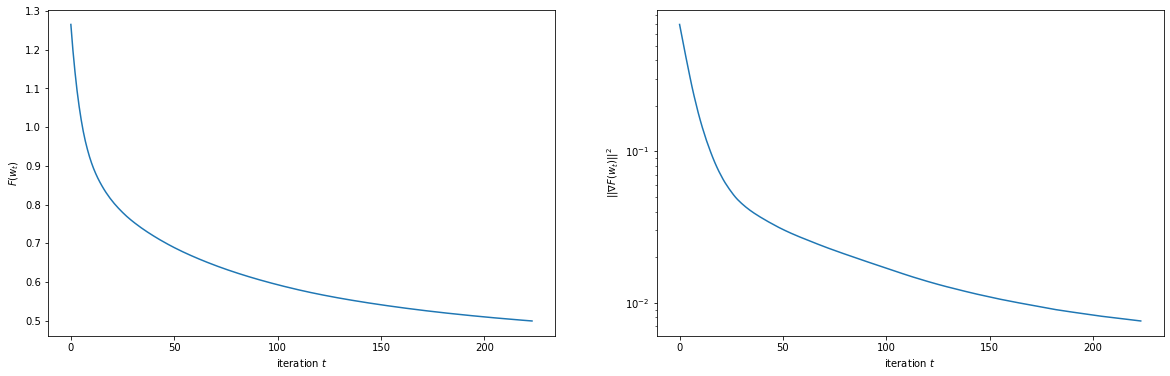

In [180]:
fig, (ax1, ax2) = plt.subplots(1, 2);fig.set_size_inches(20, 6)
ax1.plot(data[:,0]);ax1.set_ylabel(r"$F(w_t)$");ax1.set_xlabel(r"iteration $t$")  
ax2.semilogy(data[:,1]);ax2.set_ylabel(r"$||\nabla F(w_t)||^2$");ax2.set_xlabel(r"iteration $t$") 

TODO: Hessian, scaling...